## Extract the data into pandas dataframes

In [1]:
import pandas as pd

# read the data into pandas dataframes
# ---------- 2013 ----------
train2013 = pd.read_excel(r'./downloaded - xslx transformed/twitter-2013train-A.xlsx')
test2013 = pd.read_excel(r'./downloaded - xslx transformed/twitter-2013test-A.xlsx')
dev2013 = pd.read_excel(r'./\downloaded - xslx transformed/twitter-2013dev-A.xlsx')

# ---------- 2014 ----------
sarcasm2014 = pd.read_excel(r'./downloaded - xslx transformed/twitter-2014sarcasm-A.xlsx')
test2014 = pd.read_excel(r'./downloaded - xslx transformed/twitter-2014test-A.xlsx')

# ---------- 2015 ----------
train2015 = pd.read_excel(r'./downloaded - xslx transformed/twitter-2015train-A.xlsx')
test2015 = pd.read_excel(r'./downloaded - xslx transformed/twitter-2015test-A.xlsx')

# ---------- 2016 ----------
train2016 = pd.read_excel(r'./downloaded - xslx transformed/twitter-2016train-A.xlsx')
test2016 = pd.read_excel(r'./downloaded - xslx transformed/twitter-2016test-A.xlsx')
dev2016 = pd.read_excel(r'./downloaded - xslx transformed/twitter-2016train-A.xlsx')
dev_test2016 = pd.read_excel(r'./downloaded - xslx transformed/twitter-2016devtest-A.xlsx')

## Data Preprocessing

In [2]:
# merge all training dataframes into one
train_dataframes = [train2013, sarcasm2014, train2015, train2016]
train_data = pd.concat(train_dataframes)

# merge all dev dataframes into one
dev_dataframes = [dev2013, dev2016, dev_test2016]
dev_data = pd.concat(dev_dataframes)

# merge all test dataframes into one
test2016.pop('Column4')
test_dataframes = [test2013, test2014, test2015, test2016]
test_data = pd.concat(test_dataframes)

In [3]:
# rename the columns
train_data = train_data.rename(columns={'Column1': 'id', 'Column2': 'label', 'Column3':'tweet'})
dev_data = dev_data.rename(columns={'Column1': 'id', 'Column2': 'label', 'Column3':'tweet'})
test_data = test_data.rename(columns={'Column1': 'id', 'Column2': 'label', 'Column3':'tweet'})

In [4]:
# change the labels from categorical ('positive', 'negative', 'neutral') to numerical (1, -1, 0)
train_data['label_encoded'] = train_data['label'].map({'positive': 1, 'negative': -1, 'neutral': 0})
dev_data['label_encoded'] = dev_data['label'].map({'positive': 1, 'negative': -1, 'neutral': 0})
test_data['label_encoded'] = test_data['label'].map({'positive': 1, 'negative': -1, 'neutral': 0})

### Take a look at the tweets

In [5]:
tweet_lengths = [len(train_data.tweet.to_list()[i]) for i in range(len(train_data.tweet))]

In [6]:
# get the min-max lengths of the tweets 
print('Min length (character length, not number of words) of tweets: ', min(tweet_lengths))
print('Max length (character length, not number of words) of tweets: ', max(tweet_lengths))

Min length (character length, not number of words) of tweets:  22
Max length (character length, not number of words) of tweets:  200


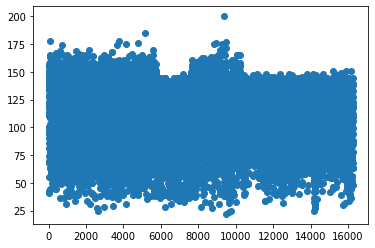

In [7]:
# plot the range of tweet lengths in the train dataset
import matplotlib.pyplot as plt

x_vals = range(len(train_data.tweet))
y_vals = tweet_lengths

plt.scatter(x_vals,y_vals)
plt.show()

Visibly, the tweets have pretty varied lengths

In [8]:
# split the data into X and y
X_train = train_data['tweet'].to_list()
y_train = train_data['label_encoded'].to_list()

X_dev = dev_data['tweet'].to_list()
y_dev = dev_data['label_encoded'].to_list()

X_test = test_data['tweet'].to_list()
y_test = test_data['label_encoded'].to_list()

## Create a baseline model

- As a pre-processing step for this model, use TF-IDF to vectorize our data
- The classifier chosen for the baseline model is: Naive-Bayes

In [9]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bogda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import re


def text_preprocessing(tweet):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    # lower-case the text of the tweet
    tweet = tweet.lower()
    
    # Change 't to 'not'
    tweet = re.sub(r"\'t", " not", tweet)
    
    # Remove @name
    tweet = re.sub(r'(@.*?)[\s]', ' ', tweet)
    
    # Isolate and remove punctuations except '?'
    tweet = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', tweet)
    tweet = re.sub(r'[^\w\s\?]', ' ', tweet)
    
    # Remove some special characters
    tweet = re.sub(r'([\;\:\|•«\n])', ' ', tweet)
    
    # Remove stopwords except 'not' and 'can'
    tweet = " ".join([word for word in tweet.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    
    # Remove trailing whitespace
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    
    return tweet

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_dev_preprocessed = np.array([text_preprocessing(text) for text in X_dev])
X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test])

# TF-IDF
tf_idf = TfidfVectorizer(# the number of words to capture (unigrams, bigrams, trigrams)
                         ngram_range=(1, 3),
                         binary=True,
                         # avoid division by 0
                         smooth_idf=False)

X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_dev_tfidf = tf_idf.transform(X_dev_preprocessed)
X_test_tfidf = tf_idf.transform(X_test_preprocessed)

### Fit the data to the model

In [12]:
from sklearn.naive_bayes import MultinomialNB

# create the model
baseline_model = MultinomialNB()

# fit the data to the model
baseline_model.fit(X_train_tfidf, y_train)

# get the score
baseline_model.score(X_test_tfidf, y_test)

0.5503483217226093

The Multinomial Naive-Bayes algorithm returns a mean accuracy of 55.03%. 

The above method is the same as doing the following:

In [13]:
from sklearn.metrics import accuracy_score

baseline_predictions = baseline_model.predict(X_test_tfidf)

accuracy_s = accuracy_score(baseline_predictions, y_test)

print(accuracy_s)

0.5503483217226093


## LSTM model

In [12]:
print('Train dataset size:', X_train_preprocessed.shape[0])
print('Dev dataset size:', X_dev_preprocessed.shape[0])
print('Test dataset size:', X_test_preprocessed.shape[0])

Train dataset size: 16259
Dev dataset size: 9654
Test dataset size: 28422


In [16]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from sklearn.feature_extraction.text import CountVectorizer

#### Map the tweets from Vocabulary to int (Tokenize the text)

In [58]:
# keep only the top 5000 most common words
train_tokenizer = Tokenizer(num_words = 5000, split = ' ')
train_tokenizer.fit_on_texts(X_train_preprocessed)

X_train_seq = train_tokenizer.texts_to_sequences(X_train_preprocessed)
X_train_seq = pad_sequences(X_train_seq, maxlen = 100)

# repeat for dev and test sets
dev_tokenizer = Tokenizer(num_words = 5000, split = ' ')
dev_tokenizer.fit_on_texts(X_dev_preprocessed)

X_dev_seq = dev_tokenizer.texts_to_sequences(X_dev_preprocessed)
X_dev_seq = pad_sequences(X_dev_seq, maxlen = 100)

test_tokenizer = Tokenizer(num_words = 5000, split = ' ')
test_tokenizer.fit_on_texts(X_test_preprocessed)

X_test_seq = test_tokenizer.texts_to_sequences(X_test_preprocessed)
X_test_seq = pad_sequences(X_test_seq, maxlen = 100)


In [19]:
from sklearn.preprocessing import LabelEncoder

# Encode the labels
train_enc = LabelEncoder()
train_data['label_encoded2'] = train_enc.fit_transform(train_data['label'])

dev_enc = LabelEncoder()
dev_data['label_encoded2'] = dev_enc.fit_transform(dev_data['label'])

test_enc = LabelEncoder()
test_data['label_encoded2'] = test_enc.fit_transform(test_data['label'])

In [23]:
y_train_lstm = np.array(train_data['label_encoded2'])
y_dev_lstm = np.array(dev_data['label_encoded2'])
y_test_lstm = np.array(test_data['label_encoded2'])

In [50]:
X_train_seq.shape[1]

30

## Fine-tune a BERT Model

In [64]:
def text_preprocessing_bert(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [67]:
X_train_bert = np.array([text_preprocessing_bert(text) for text in X_train])            
X_dev_bert = np.array([text_preprocessing_bert(text) for text in X_dev])
X_test_bert = np.array([text_preprocessing_bert(text) for text in X_test])

In [92]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data, MAX_LEN):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing_bert(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)

    return input_ids, attention_masks

In [78]:
# count the maximum number of words in the tweets
n_train = 0
n_dev = 0
n_test = 0

for tweet in X_train_bert:
    if n_train <= len(tweet.split()):
        n_train = len(tweet.split())
        
for tweet in X_dev_bert:
    if n_dev <= len(tweet.split()):
        n_dev = len(tweet.split())
        
for tweet in X_test_bert:
    if n_test <= len(tweet.split()):
        n_test = len(tweet.split())

In [82]:
print('Max number of words in the training tweets: ', n_train)
print('Max number of words in the dev tweets: ', n_dev)
print('Max number of words in the test tweets: ', n_test)

Max number of words in the training tweets:  35
Max number of words in the dev tweets:  34
Max number of words in the test tweets:  33


In [86]:
# put all tweets together
all_tweets = np.concatenate([X_train_bert, X_dev_bert, X_test_bert])

# Encode the tweets
encoded_tweets = [tokenizer.encode(text, add_special_tokens=True) for text in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  112


In [101]:
# Preprocess the inputs and turn them into tensors
X_train_inputs, X_train_mask = preprocessing_for_bert(X_train_bert, 100)
X_dev_inputs, X_dev_mask = preprocessing_for_bert(X_dev_bert, 100)
X_test_inputs, X_test_mask = preprocessing_for_bert(X_test_bert, 100)

# turn the labels into tensors
y_train_tensor = tf.convert_to_tensor(y_train_lstm)
y_dev_tensor = tf.convert_to_tensor(y_dev_lstm)
y_test_tensor = tf.convert_to_tensor(y_test_lstm)

In [106]:
from transformers import TFBertModel, BertConfig, TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [107]:
log_dir = r'D:\Facultate\Year 1\Semester 1\Text Mining\A3\bert_model'
model_save_path = r'D:\Facultate\Year 1\Semester 1\Text Mining\A3\bert_model/bert_model_TM_A3.h5'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath = model_save_path,
                                       save_weights_only= True,
                                       monitor = 'val_loss',
                                       mode = 'min',
                                       save_best_only = True),
    tf.keras.callbacks.TensorBoard(log_dir = log_dir)
]

print(model.summary())

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_39 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  2307      
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________
None


In [108]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon = 1e-08)

model.compile(loss = loss, optimizer = optimizer, metrics = [metric])

In [1]:
history_bert = model.fit([X_train_inputs, X_train_mask],
                         y_train_tensor,
                         batch_size = 32,
                         epochs = 4,
                         validation_data = ([X_dev_inputs, X_dev_mask], y_dev_tensor),
                         callbacks = callbacks)